In [1]:
from sklearn import svm
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()

np.random.seed(42)

#Read in the data file from the local directory
df = pd.read_csv('data.csv')

df['Bankrupt?'] = pd.Categorical(df['Bankrupt?'])

#Set the bankrupt feature as the target feature
dependentVariable = ['Bankrupt?']

In [2]:
#Crunch low, Mid, and High values into three separate feature groups
#This is for easier graphing of data in 3 dimensions and application of SVM

#Feature Group A is the low values
featureGroupA = [
    'Tax rate (A)',
    'Net Value Per Share (B)',
    'Net Value Per Share (A)',
    'Net Value Per Share (C)',
    'Persistent EPS in the Last Four Seasons',
    'Operating Profit Per Share (Yuan ¥)',
    'Per Share Net profit before tax (Yuan ¥)',
    'Debt ratio %',
    'Operating profit/Paid-in capital',
    'Net profit before tax/Paid-in capital',
    'Quick Assets/Total Assets',
    'Cash/Total Assets',
    'Current Liability to Assets',
    'Total expense/Assets',
    'Equity to Long-term Liability',
    'Liability-Assets Flag',
    'Equity to Liability'
    ]

#Strip formatting for easier matching with columns in dependent variable data frame
df.columns = df.columns.str.strip().str.lower()
independentVariablesA = [col.lower() for col in featureGroupA]

#Create independentVariableA by taking the per row average of feature group A
df['independentVariableA'] = df[independentVariablesA].mean(axis=1)

#Group B contains the high values
featureGroupB = [
    'Operating Gross Margin',
    'Realized Sales Gross Margin',
    'Net worth/Assets',
    'Working Capital to Total Assets',
    'Working Capital/Equity',
    'Retained Earnings to Total Assets',
    'Current Liability to Current Assets',
    'Net Income to Total Assets',
    'Gross Profit to Sales',
    'Net Income to Stockholder\'s Equity'
]

independentVariablesB = [col.lower() for col in featureGroupB]
df['independentVariableB'] = df[independentVariablesB].mean(axis=1)

#Feature Group C contains the mid values
featureGroupC = [
    'CFO to Assets',
    'Borrowing dependency',
    'Operating profit per person',
    'ROA(A) before interest and % after tax',
    'ROA(B) before interest and depreciation after tax',
    'ROA(C) before interest and depreciation before interest',
    'Current Liabilities/Equity',
    'Current Liability to Equity',
    'Liability to Equity'
]

independentVariablesC = [col.lower() for col in featureGroupC]
df['independentVariableC'] = df[independentVariablesC].mean(axis=1)

dependentVariable = [col.lower() for col in dependentVariable]

In [3]:
#Set up the data and fit the models

#Combine into X
X = df[['independentVariableA', 'independentVariableB', 'independentVariableC']]

#Name Y
Y = df[dependentVariable]

#Flatten
Y = Y.values.ravel()

#Data is split into 80% Training - 20% Test
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

#C=100000 gives a high penalty for misclassification
#Raising the penalty improved performance on the training data
#Final evaluation proved this to be the correct approach as test data performed almost as well
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", svm.LinearSVC(C=100000, loss="squared_hinge", max_iter=10000))
])

polynomial_svm_clf.fit(trainX, trainY)

#C=1000 is still a high penalty
#This model is significantly more complex, using degree 15
#The max iteration appears to have little effect on the outcome, as evaluation will find
polynomial_svm_clf2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=15)),
    ("scaler", StandardScaler()),
    ("svm_clf", svm.LinearSVC(C=1000, loss="hinge", max_iter=1000))
])

polynomial_svm_clf2.fit(trainX, trainY)

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=15)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=1000, loss='hinge'))])

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


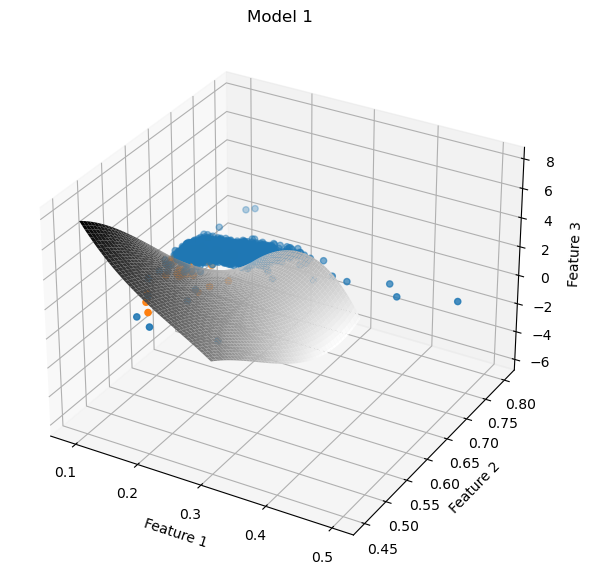

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


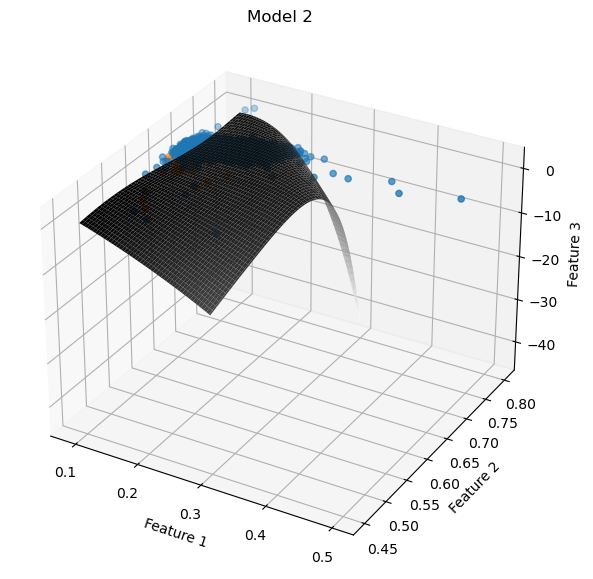

In [4]:
#Plot the models

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

levels = [0]

#These functions are modified versions of those presented by Geron in https://github.com/ageron/handson-ml2
#One major difference in their usage here is that we are fitting/predicting based on three instead of two independent features

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x2s = np.linspace(axes[4], axes[5], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    x2_fixed = np.mean(x2s)
    x2 = np.full_like(x0, x2_fixed)
    X = np.c_[x0.ravel(), x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    ax.plot_surface(x0, x1, y_decision, cmap="binary")
    
def plot_dataset(X, y, axes):
    ax.scatter(X.iloc[:, 0][y==0], X.iloc[:, 1][y==0], X.iloc[:, 2][y==0], "bs")
    ax.scatter(X.iloc[:, 0][y==1], X.iloc[:, 1][y==1], X.iloc[:, 2][y==1], "g^")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title('Model 1')

plot_predictions(polynomial_svm_clf, [.1, .3, .45, .8, .3, .5])
plot_dataset(trainX, trainY, [.1, .3, .45, .8, .3, .5])

plt.show()

fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111, projection='3d')

def plot_predictions2(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x2s = np.linspace(axes[4], axes[5], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    #Set the third feature to the mean of it's values to simplify this operation
    x2_fixed = np.mean(x2s)
    x2 = np.full_like(x0, x2_fixed)
    #Flatten x0, x1, and x2
    X = np.c_[x0.ravel(), x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    ax2.plot_surface(x0, x1, y_decision, cmap="binary")
    
def plot_dataset2(X, y, axes):
    ax2.scatter(X.iloc[:, 0][y==0], X.iloc[:, 1][y==0], X.iloc[:, 2][y==0], "bs")
    ax2.scatter(X.iloc[:, 0][y==1], X.iloc[:, 1][y==1], X.iloc[:, 2][y==1], "g^")
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.set_zlabel('Feature 3')
    ax2.set_title('Model 2')

plot_predictions2(polynomial_svm_clf2, [.1, .3, .45, .8, .3, .5])
plot_dataset2(trainX, trainY, [.1, .3, .45, .8, .3, .5])

plt.show()

In [5]:
print('Evaluation: ')
trainPredictions = polynomial_svm_clf.predict(trainX)
testPredictions = polynomial_svm_clf.predict(testX)

trainAccuracy = accuracy_score(trainY, trainPredictions)
testAccuracy = accuracy_score(testY, testPredictions)

print('The training accuracy of this model was ', trainAccuracy * 100, '%')
print('The testing accuracy of this model was ', testAccuracy * 100, '%')

if (testAccuracy < (trainAccuracy - 10)):
    print('This model is overfitting')
else:
    print('This model performs consistently between training and test data')
    
trainPredictions2 = polynomial_svm_clf2.predict(trainX)
testPredictions2 = polynomial_svm_clf2.predict(testX)

trainAccuracy2 = accuracy_score(trainY, trainPredictions2)
testAccuracy2 = accuracy_score(testY, testPredictions2)

print('The training accuracy of Model 2 was ', trainAccuracy2 * 100, '%')
print('The testing accuracy of Model 2 was ', testAccuracy2 * 100, '%')

if (testAccuracy2 < (trainAccuracy2 - 10)):
    print('Model 2 is overfitting')
else:
    print('Model 2 performs consistently between training and test data')

Evaluation: 
The training accuracy of this model was  96.7186067827681 %
The testing accuracy of this model was  96.33431085043989 %
This model performs consistently between training and test data
The training accuracy of Model 2 was  96.79193400549954 %
The testing accuracy of Model 2 was  96.26099706744868 %
Model 2 performs consistently between training and test data
